In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
np.random.seed(42)

In [9]:
df = pd.read_csv('/home/nikita/Downloads/archive/Titanic-Dataset.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


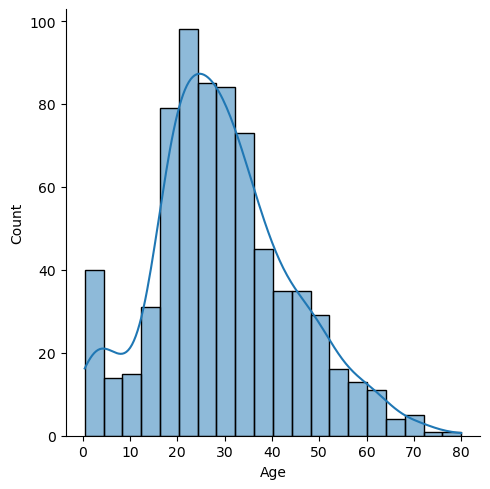

In [11]:
sns.displot(data=df, x="Age", kde=True, kind='hist')

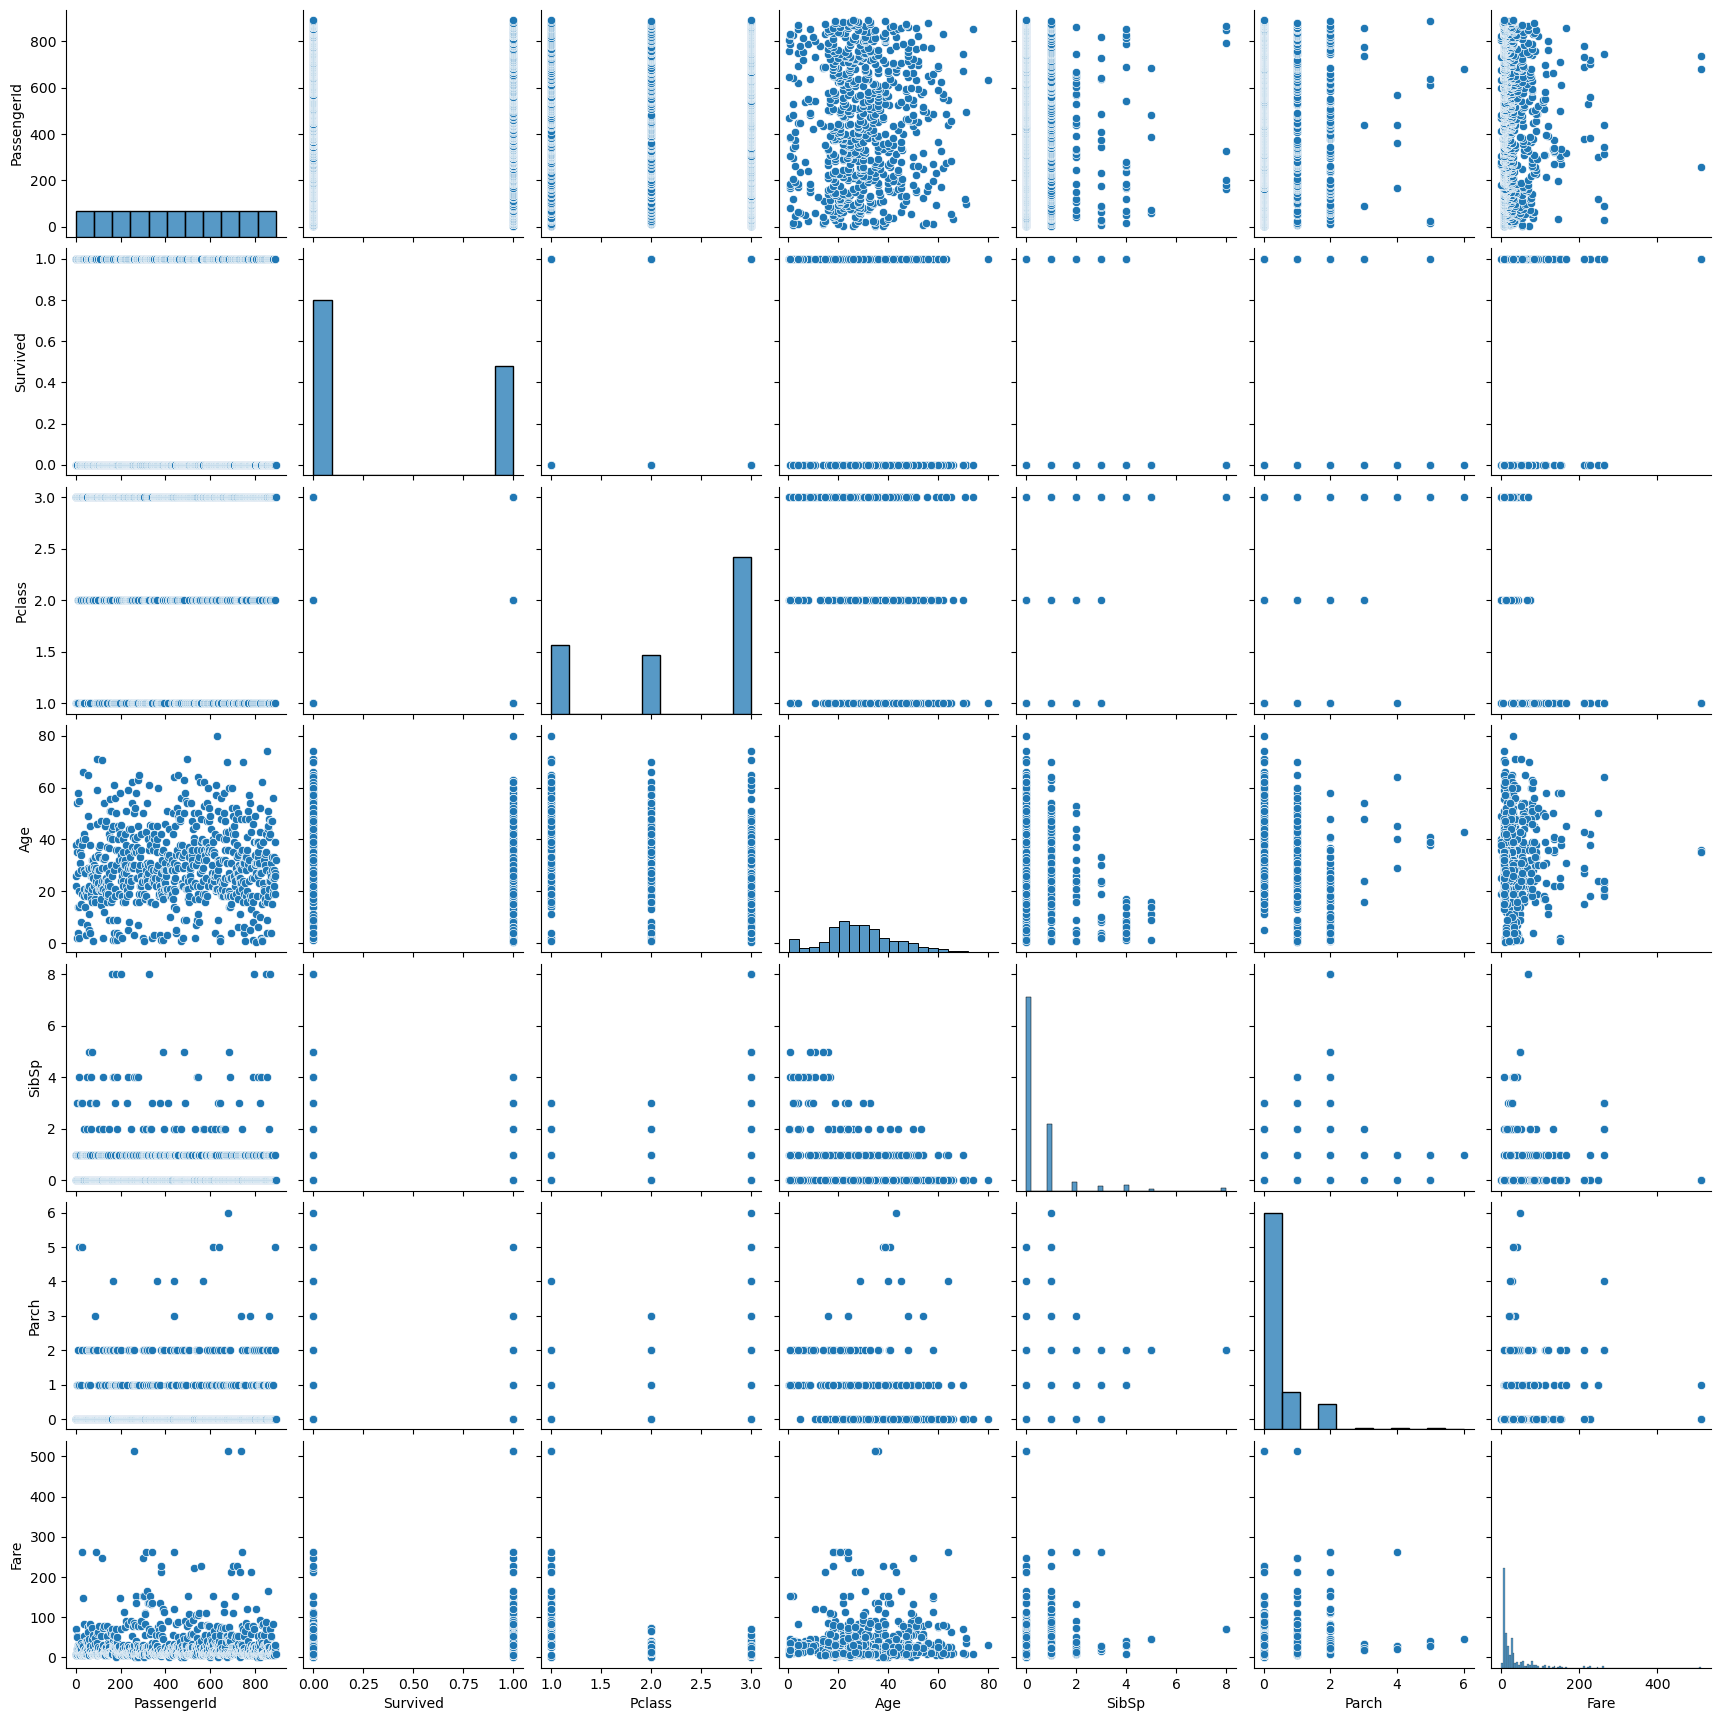

In [12]:
sns.pairplot(data=df)

In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
df.drop(['PassengerId', 'Name', 'Fare', 'Ticket', 'Embarked', 'Cabin'], axis=1, inplace=True)

In [15]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
dtype: int64

In [16]:
df['Age'].fillna(df['Age'].mean(), inplace = True)

/tmp/ipykernel_26381/2940318962.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace = True)


In [17]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

In [18]:
encoded_data = ohe.fit_transform(df[['Sex']])

In [19]:
encoded_data.drop('Sex_female', axis=1, inplace=True)

In [20]:
df['Sex'] = encoded_data

In [21]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1.0,22.000000,1,0
1,1,1,0.0,38.000000,1,0
2,1,3,0.0,26.000000,0,0
3,1,1,0.0,35.000000,1,0
4,0,3,1.0,35.000000,0,0
...,...,...,...,...,...,...
886,0,2,1.0,27.000000,0,0
887,1,1,0.0,19.000000,0,0
888,0,3,0.0,29.699118,1,2
889,1,1,1.0,26.000000,0,0


In [22]:
y = df['Survived']
X = df.drop('Survived', axis=1)

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


In [27]:
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [28]:
grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [29]:
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

In [30]:
grid_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [31]:
print(f'Best peremeters: {grid_search.best_params_}')
print(f'Best accuracy: {grid_search.best_score_}')

Best peremeters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best accuracy: 0.8282589752527013


In [32]:
from sklearn.metrics import roc_curve, auc

In [34]:
best_model = grid_search.best_estimator_

In [35]:
y_proba = best_model.predict_proba(X_test_sc)[:, 1]

In [36]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

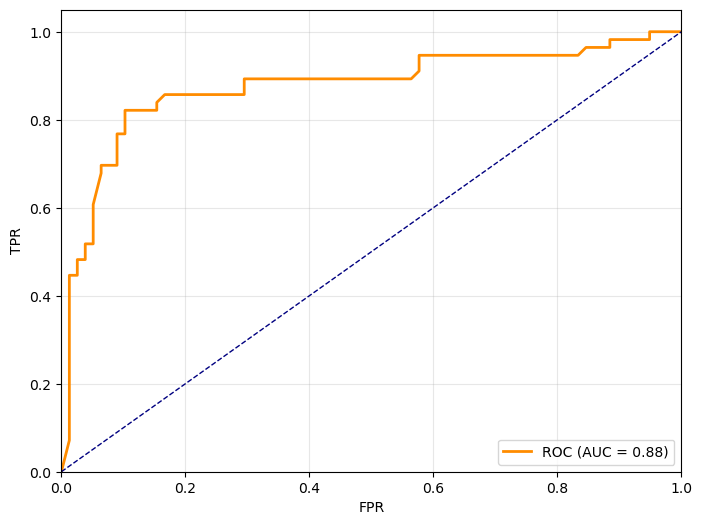

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()